In [1]:
import numpy as np
from scipy import stats


In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)

In [3]:
class self():
    distribution = 'normal'

# Code

In [4]:
class NaiveBayes():
    def __init__(self,**kwargs):
        '''
        本版代码仅仅实现了朴素贝叶斯中分类任务的代码，
        如有兴趣拓展，请参考：https://www.cs.waikato.ac.nz/~eibe/pubs/nbr.pdf
        '''
        self.distribution = kwargs.get('distribution','normal')
        
        
    def train(self,X_train,y_train,features_type):    
        self.f_type_arg_c = np.argwhere(features_type=='continuous').flatten()# 选出连续型特征列坐标
        self.f_type_arg_d = f_type_arg_d = np.argwhere(features_type=='Discrete').flatten()# 选出离散型特征列坐标
        ordered_ytrain_arg = np.argsort(y_train) #对y_train排序
        ordered_ytrain = y_train[ordered_ytrain_arg] # 排序后的y_train 
        
        self.y_unique, y_split_index, self.y_split_cnt = \
        np.unique(ordered_ytrain,return_index=True,return_counts=True)
        self.y_split_index = np.delete(y_split_index,0) #y值各类分割点
        self.cls_cnt = self.y_unique.shape[0]
        #统计排序后的ytrain y值，分割点，y值各类的数量


        #============================================
        self.y_prob = (self.y_split_cnt+1)/(ordered_ytrain.shape[0]+self.y_unique.shape[0])
        #求y中各类出现的概率
        #分子加1，分母加了类别数，是拉普拉斯修正平滑，
        #============================================

        ### continuous连续型变量处理
        X_train_con = X_train[:,self.f_type_arg_c]
        if X_train_con.shape[1]!=0:
            func_split_mean = lambda X: np.array([np.mean(arr) for arr in np.split(X,self.y_split_index)])
            split_mean = np.apply_along_axis(func_split_mean,0,X_train_con[ordered_ytrain_arg])
            #按y值，特征分割，求均值
            func_split_std = lambda X: np.array([np.std(arr) for arr in np.split(X,self.y_split_index)])
            split_std = np.apply_along_axis(func_split_std,0,X_train_con[ordered_ytrain_arg])
            #按y值，特征分割，求标准差
            def getprob_bydistribution(mean,std):
                if self.distribution == 'normal':
                    func_smooth = np.vectorize(lambda x:x or 1e-4)
                    std = func_smooth(std)#标准差不可为0，会导致正态分布无意义
                    return stats.norm(loc=mean,scale=std)
    
    
            self.Norm_array = getprob_bydistribution(split_mean,split_std)
            ## 计算正态分布矩阵


        ## Discrete 离散型=============================
        X_train_dis = X_train[:,self.f_type_arg_d]
        # 分离离散型数据为X_train_dis
        if X_train_dis.shape[1]!=0:
            all_data = [self.func_split_cnt(item,i) for i,item in enumerate(X_train_dis.T)]
            data = [d for d,col in all_data]
            self.dis_prob = np.log(np.concatenate(data,axis=1))
            #计算每个的每个值在每个y类下出现的概率。

            self.cols_dict = {}
            col_list = [col for d,col in all_data]
            list(map(lambda x:self.cols_dict.update(x),col_list))
            #生成每个特征的每个值在离散概率矩阵（self.dis_prob）中对应的偏移量
            shape_list = np.apply_along_axis(lambda x:np.unique(x).shape[0],0,X_train_dis)
            shape_list = np.insert(shape_list,0,0)
            shape_list = np.delete(shape_list,-1)
            self.base_num = np.cumsum(shape_list)
            # 计算各个特征在离散概率矩阵（self.dis_prob）开始的位置
            #特征在离散矩阵中feature位置+ 值的偏移量 == 具体特征值在离散概率矩阵中的位置。

    def func_split_cnt(self,X,col_num):
        '''
        此函数作用于离散变量
        '''
        uni_key = np.unique(X)
        uni_val =np.zeros_like(uni_key)
        def func_update_cnt(arr):
            '''
            生成每列的每个值在没个Y值下的数量
            '''
            uni_inner,uni_count = np.unique(arr,return_counts=True)
            uni_val_copy = uni_val.copy()
            uni_val_copy[np.in1d(uni_key,uni_inner)] = uni_count
            return uni_val_copy
        t = np.array([func_update_cnt(arr) for arr in np.split(X,self.y_split_index)])
        t = (t+1)/(self.y_split_cnt.reshape((self.cls_cnt,1))+uni_key.shape[0])#拉普拉斯平滑
        
        col_name = {(col_num,num):i for i,num in enumerate(uni_key)}#生成特征值偏移量
        
        return t,col_name

    def predict(self,X_test):
        base = np.zeros((X_test.shape[0],self.cls_cnt))
        X_test_con = X_test[:,self.f_type_arg_c]
        if X_test_con.shape[1]!=0:#分离连续离散变量
            vfunc = np.vectorize(lambda x:np.log(x or 1e-5))
            #对概率密度取Log（要求其不能为0，因为过小的概率密度会超过浮点数的精度而变为0）
            def func(x):
                prob_dense = self.Norm_array.pdf(x)
                prob_dense = vfunc(prob_dense)
                return prob_dense.sum(axis=1)
            prob_con = np.apply_along_axis(func,1,X_test_con)
            base += prob_con #添加连续变量概率密度和(log后)


        def dis_prob_func(X):
            '''
            计算每列的值在每个Y值下在离散型变量的概率和（已log后的）
            '''
            feature_offset = np.array([self.cols_dict.get((i,x),np.nan) for i,x in enumerate(X)])
            offset_notnan = ~np.isnan(feature_offset)
            fea_index = self.base_num[offset_notnan]+(feature_offset[offset_notnan]).astype(np.int)
            return (self.dis_prob[:,fea_index]).sum(axis=1)

        X_test_dis = X_test[:,self.f_type_arg_d]
        if X_test_dis.shape[1]!=0:
            self.cls_prob_dis = np.apply_along_axis(dis_prob_func,1,X_test_dis)
            base += self.cls_prob_dis# 加离散变量概率和（log后）
        self.prob = base*self.y_prob# 对联合概率乘积后× y类值出现概率
        return self.y_unique[self.prob.argmax(axis=1)]


In [5]:
if __name__ == '__main__':
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    from sklearn.datasets import load_digits
    digits = load_digits()
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3, random_state=42)

    #['Discrete','continuous']
    features_type2 = ['Discrete']*64
    features_type2[5:30] = ['continuous']*25
    features_type2 = np.array(features_type2)

    NB = NaiveBayes()

    NB.train(X_train,y_train,features_type2)

    t = NB.predict(X_test)

In [6]:
if __name__ == '__main__':
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    from sklearn.datasets import load_iris
    iris = load_iris()
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)

    #['Discrete','continuous']
    features_type1 = np.array(['continuous','continuous','continuous','continuous'])
    NB = NaiveBayes()
    NB.train(X_train,y_train,features_type1)
    t = NB.predict(X_test)

## 概率密度函数图

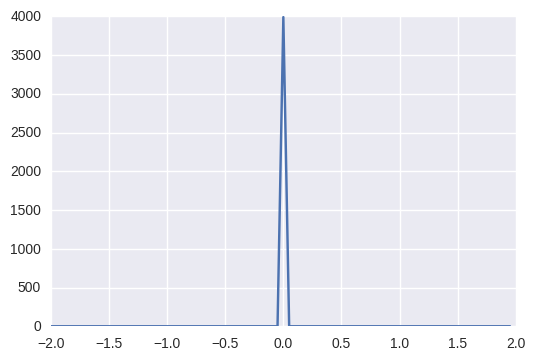

In [7]:
if __name__ == '__main__':
    
    Norm = stats.norm(0,0.0001)
    a = np.arange(-2,2,0.05)
    b = Norm.pdf(a)

    plt.plot(a,b)